In [1]:
import sys; sys.path.append('../')

import time

from src.data_loader import load_data

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/nicolas/.local/share/virtualenvs/point-cloud-learn-97nGMN1k/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
plt.rcParams["figure.figsize"] = (20,10)

# Explore Decision Trees Rules

In [3]:
clusters, _ = load_data('../data/all_clusters_points.txt')
clusters = clusters.drop(['file_origin', 'file_destination'], axis=1)

In [4]:
#Delete columns with one value
for col in clusters.columns:
    if len(clusters[col].unique()) == 1:
        clusters.drop(col,inplace=True,axis=1)

In [5]:
clusters['classification'] = (
    ((clusters['classification'] != 'Vegetation') & (clusters['classification'] != 'Limit_effect'))
)

In [6]:
max_elements_per_class = min(clusters['classification'].value_counts().values)
balanced_clusters = clusters.drop(clusters.index)
for c in clusters['classification'].unique():
    balanced_clusters = pd.concat([
        balanced_clusters,
        clusters[clusters['classification'] == c].sample(max_elements_per_class)
    ])

In [7]:
train_percentage = 0.8

data = balanced_clusters.replace('None', np.nan).dropna(axis=0)
all_data = clusters.replace('None', np.nan).dropna(axis=0)

X = data.drop('classification', axis=1)
X = (X - X.mean()) / X.std()
y = data['classification']

all_X = all_data.drop('classification', axis=1)
all_X = (all_X - all_X.mean()) / all_X.std()
all_y = all_data['classification']

train_indexes, test_indexes = next(StratifiedShuffleSplit(n_splits=1, train_size=0.8).split(X, y))
X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
X_test, y_test = X.iloc[test_indexes], y.iloc[test_indexes]

#X_val, y_val = X.iloc[test_indexes], y.iloc[test_indexes]
X_all_test, y_all_test = all_X.loc[~all_X.index.isin(X.index)], all_y.loc[~all_X.index.isin(X.index)]

X_all_test = pd.concat([X_all_test, X_test])
y_all_test = pd.concat([y_all_test, y_test])

In [8]:
print(y_test.value_counts(),'\n', y_train.value_counts())

True     11
False    11
Name: classification, dtype: int64 
 True     44
False    44
Name: classification, dtype: int64


## Balanced Data

In [9]:
from sklearn.tree import DecisionTreeClassifier

In [10]:
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

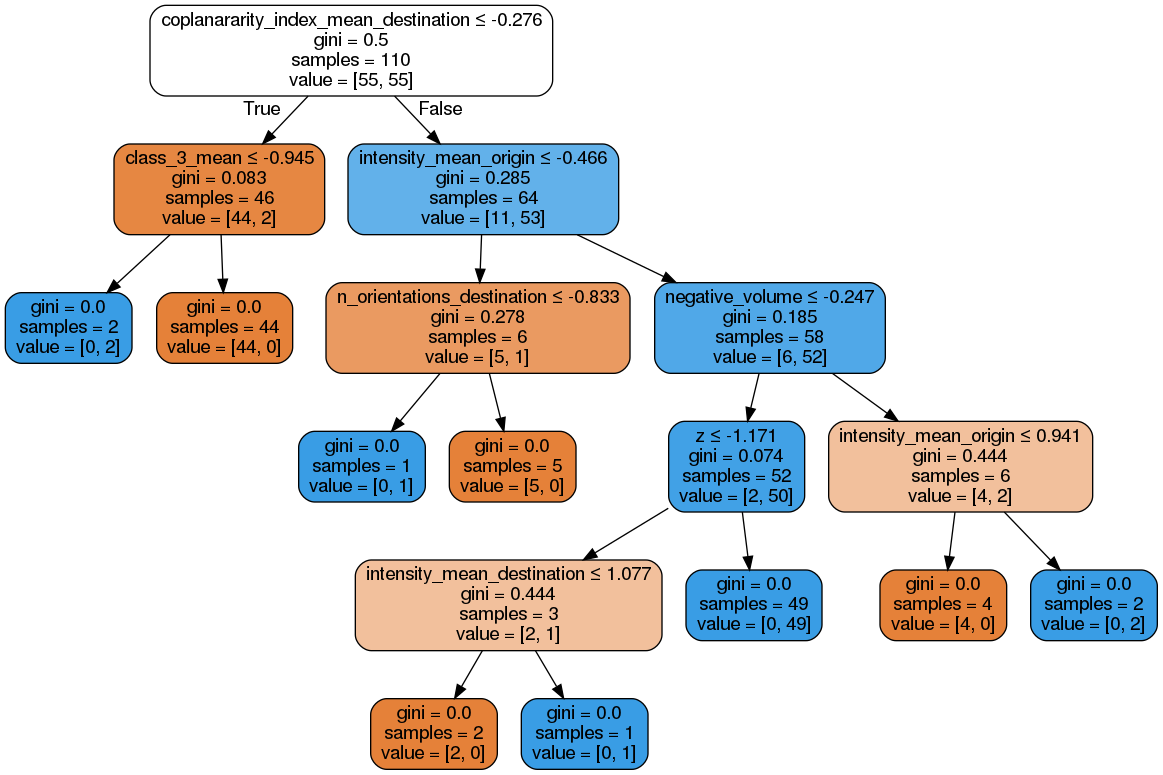

In [11]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import pydotplus


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## All Data

clf = DecisionTreeClassifier()
clf.fit(all_X, all_y)

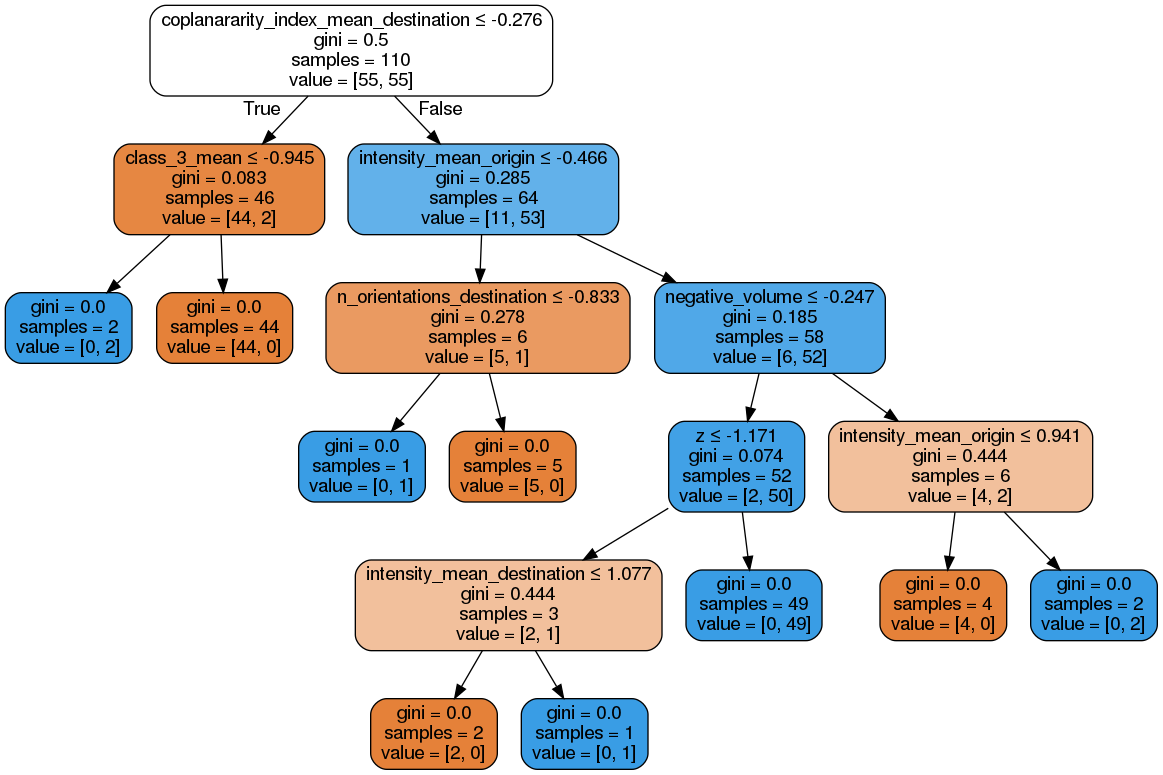

In [12]:
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import pydotplus


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names = X.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

We can see that coplanarity, colinearity and intensity are the features that define most of the rules